**Useless**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display, Image
import warnings

# Suppress potential UserWarnings from matplotlib
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# --- Block 1: Setup and Configuration ---
print("--- Block 1: Setup and Configuration ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

--- Block 1: Setup and Configuration ---
Using device: cuda


In [4]:

# --- Block 2: Data Loading and Preprocessing ---
print("\n--- Block 2: Data Loading and Preprocessing ---")
try:
    # Adjust the path to your NetCDF file
    ds = xr.open_dataset('RBC_Output.nc')
except FileNotFoundError:
    print("ERROR: 'RBC_Output.nc' not found. Please adjust the path.")
    # As a fallback, create dummy data to allow the script to run
    print("Creating dummy data for demonstration purposes.")
    ds = xr.Dataset(
        {
            'b': (('time', 'z_aac', 'x_caa'), np.random.rand(50, 50, 128)),
            'u': (('time', 'z_aac', 'x_faa'), np.random.rand(50, 50, 128)),
            'w': (('time', 'z_aaf', 'x_caa'), np.random.rand(50, 50, 128)),
            'p_dyn': (('time', 'z_aac', 'x_caa'), np.random.rand(50, 50, 128)),
            'time': ('time', np.arange(0, 25, 0.5)),
            'z_aac': ('z_aac', np.linspace(-1, 0, 50)),
            'x_caa': ('x_caa', np.linspace(-1, 1, 128)),
            'z_aaf': ('z_aaf', np.linspace(-1, 0, 50)),
            'x_faa': ('x_faa', np.linspace(-1, 1, 128)),
        }
    )


# Grid selection
z_full = ds['z_aac'].values
x_full = ds['x_caa'].values
z_sel_idx = np.linspace(0, len(z_full) - 1, 50, dtype=int)
x_sel_idx = np.linspace(0, len(x_full) - 1, 128, dtype=int)
z_vals = z_full[z_sel_idx]
x_vals = x_full[x_sel_idx]

# Slicing function
def slice_field(field, z_dim, x_dim, time_slice):
    return np.array(field.isel(time=time_slice, **{z_dim: z_sel_idx, x_dim: x_sel_idx}).values, dtype=np.float32)

# Use a limited number of time steps
max_time_steps = 50
time_slice = slice(0, max_time_steps)

b_raw = slice_field(ds['b'], 'z_aac', 'x_caa', time_slice)
u_raw = slice_field(ds['u'], 'z_aac', 'x_faa', time_slice)
w_raw = slice_field(ds['w'], 'z_aaf', 'x_caa', time_slice)
p_dyn_raw = slice_field(ds['p_dyn'], 'z_aac', 'x_caa', time_slice)
time_raw = np.array(ds['time'].isel(time=time_slice).values, dtype=np.float32)

print(f"Raw shapes -> b: {b_raw.shape}, u: {u_raw.shape}, w: {w_raw.shape}, p_dyn: {p_dyn_raw.shape}")

# Compute Δb (the target)
delta_b = b_raw[1:] - b_raw[:-1]
time_d = time_raw[1:]

# Stack inputs (u, w, p_dyn at time t)
# These inputs will be used to predict delta_b from t to t+1
inputs = np.stack([u_raw[:-1], w_raw[:-1], p_dyn_raw[:-1]], axis=1).astype(np.float32)
targets = delta_b.astype(np.float32)
time_stamps = time_d.astype(np.float32)

print(f"Processed shapes -> Inputs: {inputs.shape}, Targets: {targets.shape}, Times: {time_stamps.shape}")

# Normalization
subset = min(10, inputs.shape[0])
inputs_mean, inputs_std = inputs[:subset].mean(), inputs[:subset].std()
targets_mean, targets_std = targets[:subset].mean(), targets[:subset].std()
time_min, time_max = time_stamps.min(), time_stamps.max()

inputs_norm = (inputs - inputs_mean) / (inputs_std + 1e-8)
targets_norm = (targets - targets_mean) / (targets_std + 1e-8)
time_norm = (time_stamps - time_min) / (time_max - time_min)
print("Normalization complete.")

# Convert to Tensors
X_tensor = torch.tensor(inputs_norm, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(targets_norm, dtype=torch.float32).to(device)
t_tensor = torch.tensor(time_norm, dtype=torch.float32).unsqueeze(1).to(device)
print(f"Final tensor shapes -> X: {X_tensor.shape}, Y: {Y_tensor.shape}, t: {t_tensor.shape}")





--- Block 2: Data Loading and Preprocessing ---
ERROR: 'RBC_Output.nc' not found. Please adjust the path.
Creating dummy data for demonstration purposes.
Raw shapes -> b: (50, 50, 128), u: (50, 50, 128), w: (50, 50, 128), p_dyn: (50, 50, 128)
Processed shapes -> Inputs: (49, 3, 50, 128), Targets: (49, 50, 128), Times: (49,)
Normalization complete.
Final tensor shapes -> X: torch.Size([49, 3, 50, 128]), Y: torch.Size([49, 50, 128]), t: torch.Size([49, 1])


In [5]:
# --- Block 3: Model Definition (DeepONetCNN) ---
print("\n--- Block 3: Model Definition ---")
class DeepONetCNN(nn.Module):
    def __init__(self):
        super(DeepONetCNN, self).__init__()
        self.branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Flatten(start_dim=1)
        )
        self.trunk = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 50 * 128),
        )
    def forward(self, x, t):
        B_out = self.branch(x)
        T_out = self.trunk(t)
        out = B_out * T_out
        out = out.view(-1, 50, 128)
        return out
print("DeepONetCNN class defined.")



--- Block 3: Model Definition ---
DeepONetCNN class defined.


In [6]:
# --- Block 4: Physics Loss Function ---
print("\n--- Block 4: Physics Loss Function ---")
def compute_physics_loss(
    model, 
    inputs_norm, 
    times_norm, 
    inputs_unnorm, 
    b_initial_unnorm,
    constants
):
    """Computes the physics-informed loss based on the Boussinesq equations."""
    # 1. Get Model Prediction and Denormalize
    pred_delta_b_norm = model(inputs_norm, times_norm)
    pred_delta_b = pred_delta_b_norm * constants['targets_std'] + constants['targets_mean']
    b_final = b_initial_unnorm + pred_delta_b
    u, w, p_dyn = inputs_unnorm[:, 0], inputs_unnorm[:, 1], inputs_unnorm[:, 2]

    # 2. Compute Derivatives (2nd-order central differences)
    # Note: Using central differences reduces tensor dimensions by 2 on each axis.
    def central_diff(field, dx, axis):
        if axis == 'x':
            return (field[:, :, 2:] - field[:, :, :-2]) / (2 * dx)
        elif axis == 'z':
            return (field[:, 2:, :] - field[:, :-2, :]) / (2 * dx)
    def laplacian(field, dx, dz):
        f_xx = (field[:, :, 2:] - 2 * field[:, :, 1:-1] + field[:, :, :-2]) / (dx**2)
        f_zz = (field[:, 2:, :] - 2 * field[:, 1:-1, :] + field[:, :-2, :]) / (dz**2)
        return f_xx[:, 1:-1, :] + f_zz[:, :, 1:-1]

    b_initial_x = central_diff(b_initial_unnorm, constants['dx'], 'x')
    b_initial_z = central_diff(b_initial_unnorm, constants['dz'], 'z')
    laplacian_b = laplacian(b_initial_unnorm, constants['dx'], constants['dz'])
    
    w_x = central_diff(w, constants['dx'], 'x')
    w_z = central_diff(w, constants['dz'], 'z')
    laplacian_w = laplacian(w, constants['dx'], constants['dz'])
    
    p_dyn_z = central_diff(p_dyn, constants['dz'], 'z')

    # 3. Crop All Fields to Match Derivative Shapes (z-2, x-2)
    u_c = u[:, 1:-1, 1:-1]
    w_c = w[:, 1:-1, 1:-1]
    b_final_c = b_final[:, 1:-1, 1:-1]
    pred_delta_b_c = pred_delta_b[:, 1:-1, 1:-1]

    # 4. Calculate Physics Residuals
    # Residual 1: Buoyancy Transport -> ∂b/∂t + u⋅∇b - κ∇²b = 0
    db_dt = pred_delta_b_c / constants['dt']
    advection_b = u_c * b_initial_x[:, 1:-1, :] + w_c * b_initial_z[:, :, 1:-1]
    diffusion_b = constants['κ'] * laplacian_b
    residual_1 = db_dt + advection_b - diffusion_b

    # Residual 2: Vertical Momentum -> b - (u⋅∇w + ∂p/∂z - ν∇²w) = 0
    advection_w = u_c * w_x[:, 1:-1, :] + w_c * w_z[:, :, 1:-1]
    diffusion_w = constants['ν'] * laplacian_w
    residual_2 = b_final_c - (advection_w + p_dyn_z[:, :, 1:-1] - diffusion_w)
    
    # 5. Compute Final Loss
    loss_b_transport = torch.mean(residual_1 ** 2)
    loss_w_momentum = torch.mean(residual_2 ** 2)
    
    return loss_b_transport + loss_w_momentum
print("`compute_physics_loss` function defined.")



--- Block 4: Physics Loss Function ---
`compute_physics_loss` function defined.


In [7]:
# --- Block 5: Training Preparation ---
print("\n--- Block 5: Training Preparation ---")
# Create a dictionary for constants
constants = {
    'dt': np.mean(np.diff(time_raw)),
    'dx': np.mean(np.diff(x_vals)),
    'dz': np.mean(np.diff(z_vals)),
    'ν': 1e-6,
    'κ': 1e-6,
    'targets_mean': torch.tensor(targets_mean, device=device),
    'targets_std': torch.tensor(targets_std, device=device)
}
print(f"Physics constants prepared: {constants}")

# Prepare unnormalized data tensors for physics loss calculation
inputs_unnorm_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
b_initial_unnorm_tensor = torch.tensor(b_raw[:-1], dtype=torch.float32).to(device)

# Create training/testing splits
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_idx, test_idx = torch.utils.data.random_split(range(len(X_tensor)), [train_size, test_size])

X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
t_train, t_test = t_tensor[train_idx], t_tensor[test_idx]
Y_train, Y_test = Y_tensor[train_idx], Y_tensor[test_idx]

# Unnormalized splits for physics loss
inputs_unnorm_train = inputs_unnorm_tensor[train_idx]
b_initial_unnorm_train = b_initial_unnorm_tensor[train_idx]
time_test_np = time_stamps[test_idx.indices] # For plotting

print(f"Data split -> Train: {len(X_train)}, Test: {len(X_test)}")



--- Block 5: Training Preparation ---
Physics constants prepared: {'dt': np.float32(0.5), 'dx': np.float64(0.015748031496062992), 'dz': np.float64(0.02040816326530612), 'ν': 1e-06, 'κ': 1e-06, 'targets_mean': tensor(6.4511e-05, device='cuda:0'), 'targets_std': tensor(0.4099, device='cuda:0')}
Data split -> Train: 39, Test: 10


In [8]:
# --- Block 6: Training Loop ---
print("\n--- Block 6: Training Loop ---")
model = DeepONetCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
mse = nn.MSELoss()

num_epochs = 5000
physics_loss_weight = 0.1

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    pred_train = model(X_train, t_train)
    obs_loss = mse(pred_train, Y_train)
    
    phy_loss = compute_physics_loss(
        model, X_train, t_train, 
        inputs_unnorm_train, b_initial_unnorm_train, 
        constants
    )
    
    total_loss = obs_loss + physics_loss_weight * phy_loss
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:4d}: Total Loss={total_loss.item():.6f} | Obs Loss={obs_loss.item():.6f} | Phy Loss={phy_loss.item():.6f}")




--- Block 6: Training Loop ---
Epoch    0: Total Loss=28.886347 | Obs Loss=0.993489 | Phy Loss=278.928589
Epoch  500: Total Loss=28.524153 | Obs Loss=1.226210 | Phy Loss=272.979431
Epoch 1000: Total Loss=28.468767 | Obs Loss=1.230049 | Phy Loss=272.387177
Epoch 1500: Total Loss=28.425829 | Obs Loss=1.228732 | Phy Loss=271.970947
Epoch 2000: Total Loss=28.374235 | Obs Loss=1.219452 | Phy Loss=271.547821
Epoch 2500: Total Loss=28.300615 | Obs Loss=1.200787 | Phy Loss=270.998291
Epoch 3000: Total Loss=28.218853 | Obs Loss=1.181602 | Phy Loss=270.372498
Epoch 3500: Total Loss=28.150101 | Obs Loss=1.164896 | Phy Loss=269.852051
Epoch 4000: Total Loss=28.095539 | Obs Loss=1.152518 | Phy Loss=269.430206
Epoch 4500: Total Loss=28.053867 | Obs Loss=1.143153 | Phy Loss=269.107147
Epoch 4999: Total Loss=28.020050 | Obs Loss=1.135473 | Phy Loss=268.845764



--- Block 7: Evaluation and Visualization ---
Animation saved to PINN_deltab_animation.gif


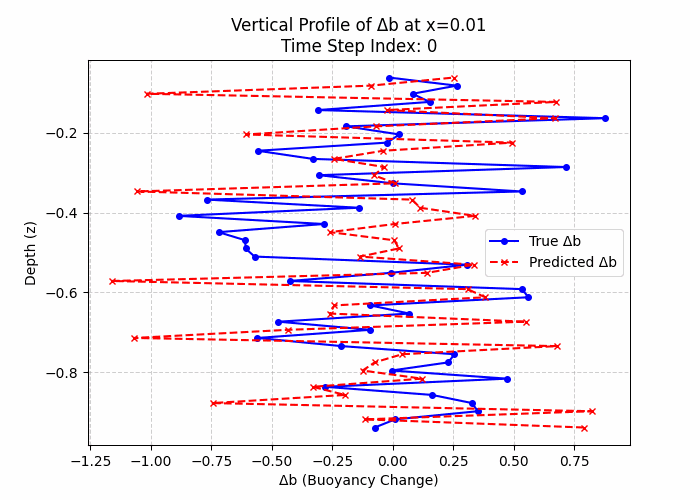

In [12]:
# --- Block 7: Evaluation and Visualization ---
print("\n--- Block 7: Evaluation and Visualization ---")
model.eval()
with torch.no_grad():
    pred_test_norm = model(X_test, t_test)

# Denormalize for visualization
pred_test = (pred_test_norm.cpu().numpy() * targets_std) + targets_mean
true_test = (Y_test.cpu().numpy() * targets_std) + targets_mean

# Select a central x-index for plotting vertical profiles
x_idx_vis = pred_test.shape[2] // 2
trim = 3 # Trim boundaries for cleaner plot
z_trimmed = z_vals[trim:-trim]

fig, ax = plt.subplots(figsize=(7, 5))

def update_animation(frame):
    ax.clear()
    true_profile = true_test[frame, trim:-trim, x_idx_vis]
    pred_profile = pred_test[frame, trim:-trim, x_idx_vis]
    
    ax.plot(true_profile, z_trimmed, 'bo-', label='True Δb', markersize=4)
    ax.plot(pred_profile, z_trimmed, 'r--x', label='Predicted Δb', markersize=4)
    
    ax.set_title(f'Vertical Profile of Δb at x={x_vals[x_idx_vis]:.2f}\nTime Step Index: {frame}')
    ax.set_xlabel('Δb (Buoyancy Change)')
    ax.set_ylabel('Depth (z)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

ani = animation.FuncAnimation(fig, update_animation, frames=len(pred_test), interval=1000, blit=False)

# Save and display the animation
try:
    gif_path = 'PINN_deltab_animation.gif'
    ani.save(gif_path, writer='pillow', fps=0.5)
    print(f"Animation saved to {gif_path}")
    display(Image(filename=gif_path))
except Exception as e:
    print(f"Could not save or display GIF. Error: {e}")
    print("Displaying animation inline instead.")
    display(HTML(ani.to_jshtml()))

plt.close(fig) # Prevent static plot from showing up
